In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 205.05844593048096


RET1_1    RET2_1    RET1_2    RET2_2    RET1_3  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.007728  0.755230  0.020093  0.794979  0.015456   
           000002.SZ   0.020498  0.903766  0.021962  0.836820 -0.004392   
           000059.SZ  -0.030303  0.171548 -0.044289  0.184100 -0.039627   
           000061.SZ  -0.035907  0.133891 -0.123878  0.008368 -0.170557   
           000063.SZ   0.040343  0.983264  0.013342  0.715481 -0.003812   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.014707  0.757895 -0.044489  0.070175 -0.045297   
           688396.SH   0.013962  0.736842 -0.000566  0.585965 -0.009623   
           688561.SH   0.021935  0.877193  0.031379  0.954386  0.023001   
           688599.SH  -0.038425  0.010526 -0.053571  0.042105 -0.140784   
           688981.SH   0.014181  0.747368  0.012958  0.817544  0.003912   

                         RET2_3    RET1_4    RET2_4    CLOSE5   ROC5  ...  \
datetime   instrument                                                 ...   
2006-04-07 000001.SZ   0.790795 -0.009274  0.661088  0.984544 -0.180  ...   
           000002.SZ   0.573222  0.008785  0.807531  0.959004 -0.144  ...   
           000059.SZ   0.280335 -0.041958  0.372385  0.925408 -0.136  ...   
           000061.SZ   0.008368 -0.170557  0.012552  0.804309  0.018  ...   
           000063.SZ   0.577406  0.013659  0.845188  0.972999 -0.030  ...   
...                         ...       ...       ...       ...    ...  ...   
2022-12-28 688363.SH   0.122807 -0.038973  0.136842  0.913302  2.158  ...   
           688396.SH   0.487719  0.012264  0.828070  1.014528 -0.354  ...   
           688561.SH   0.950877 -0.051028  0.091228  0.938309  0.610  ...   
           688599.SH   0.007018 -0.116550  0.007018  0.855389  1.614  ...   
           688981.SH   0.757895  0.004156  0.719298  1.009535 -0.278  ...   

                       MEAN2_10  MEAN2_20  MEAN2_30  MEAN2_60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.978529  0.958139  1.077550  0.969214  0.847906   
           000002.SZ   0.865644  0.732006  0.816881  0.651620  0.846304   
           000059.SZ   1.006254  0.878924  0.966881  0.795894  0.334477   
           000061.SZ   0.795945  0.803208  0.830703  0.782898  0.201339   
           000063.SZ   0.933128  0.867431  0.942097  0.921683  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.938007  0.802368  0.840133  0.980244  0.391778   
           688396.SH   1.089137  0.996531  1.017298  0.900445  1.674625   
           688561.SH   0.991060  0.925343  1.039368  0.684092  0.494056   
           688599.SH   0.882503  1.052199  1.064043  1.083195  0.528563   
           688981.SH   1.050083  0.996821  1.044376  0.924189  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  2.6700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  2.5300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -2.0700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.1800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.7900  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1141117 rows x 164 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1141117 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 164 entries, RET1_1 to label
dtypes: float64(164)
memory usage: 1.4+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


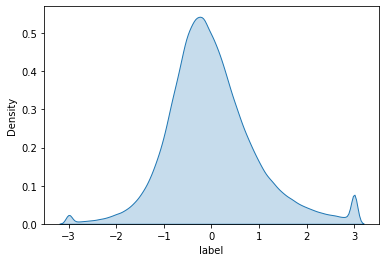

The distribution of y_valid:


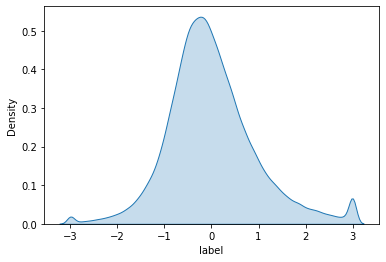

The distribution of y_test:


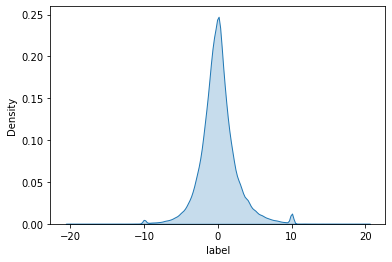

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

cnn = models.CNN(epochs=15)
cnn.fit(X_train, y_train, X_valid, y_valid)

pred = cnn.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/15
2353/2353 [==============================] - 53s 23ms/step - loss: 0.9396 - mae: 0.7246 - mape: 2511.5381 - val_loss: 0.9295 - val_mae: 0.7211 - val_mape: 2766.6011
Epoch 2/15
2353/2353 [==============================] - 58s 25ms/step - loss: 0.9045 - mae: 0.7112 - mape: 1807.6718 - val_loss: 0.9011 - val_mae: 0.7136 - val_mape: 1801.9302
Epoch 3/15
2353/2353 [==============================] - 58s 25ms/step - loss: 0.8986 - mae: 0.7091 - mape: 1566.3795 - val_loss: 0.9174 - val_mae: 0.7141 - val_mape: 2111.6389
Epoch 4/15
2353/2353 [==============================] - 58s 25ms/step - loss: 0.8924 - mae: 0.7064 - mape: 1692.4976 - val_loss: 0.9066 - val_mae: 0.7192 - val_mape: 2839.4631
Epoch 5/15
2353/2353 [==============================] - 58s 24ms/step - loss: 0.8884 - mae: 0.7047 - mape: 1069.0140 - val_loss: 0.8956 - val_mae: 0.7090 - val_mape: 2397.5481
Epoch 6/15
2353/2353 [==============================] - 58s 25ms/step - loss: 0.8852 - mae: 0.7031 - mape: 930.1661 - va

,predict
count,280721.000000
mean,-0.000192
std,0.002139
min,-0.019713
25%,-0.001470
50%,-0.000150
75%,0.001111
max,0.013678


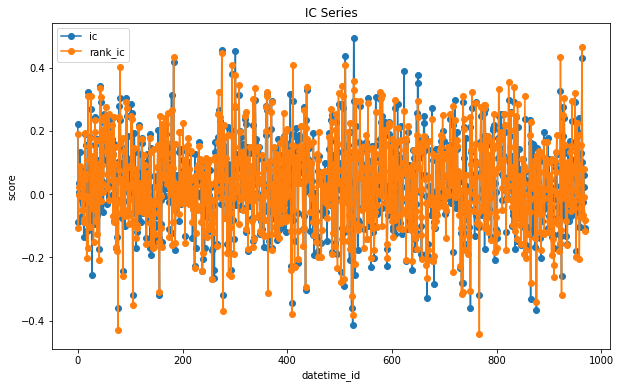

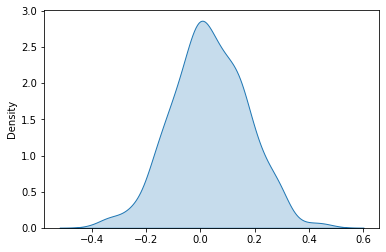

ic= 0.03270598334367948 icir= 0.2339616123413082 rank_ic= 0.033564229868589215 rank_icir= 0.23439721164089708


0.034779382415898806

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [8]:
model = cnn.model
print(model.summary())
#model.save("attention")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 52, 32)            320       
_________________________________________________________________
batch_normalization (BatchNo (None, 52, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 51, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            14400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0

Accuracy of Prediction: 0.5285459936417773


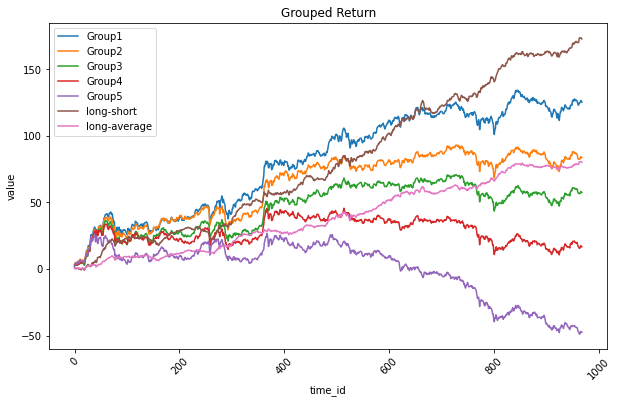

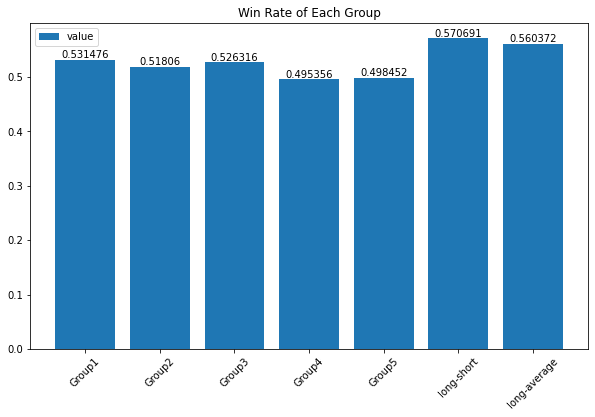

In [9]:
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.25  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.12124737743173641
Annualized Volatility: 0.3583050841332673
Annualized Return(Benchmark): 0.07903465509941188
Annualized Volatility(Benchmark): 0.33918455897903593 

Cumulative Rate of Return: 0.5527940971397352
Cumulative Rate of Return(Benchmark): 0.3397659986073198
Cumulative Excess Rate of Return: 0.21302809853241533 

Max Drawdown: -0.39210915869485397
Max Drawdown(Benchmark): -0.5464988056952731
Max Drawdown(Excess Return): -0.13757887896323084 

Sharpe Ratio: 2.5384852495947228
Sortino Ratio: 0.19584873882954887
Information Ratio: 0.2694789603592648 

Beta: 1.0026094920587618
Alpha: 0.04815769152674626
Epsilon: 0.057549373164377166
Profitable Days(%): 0.8555211558307534


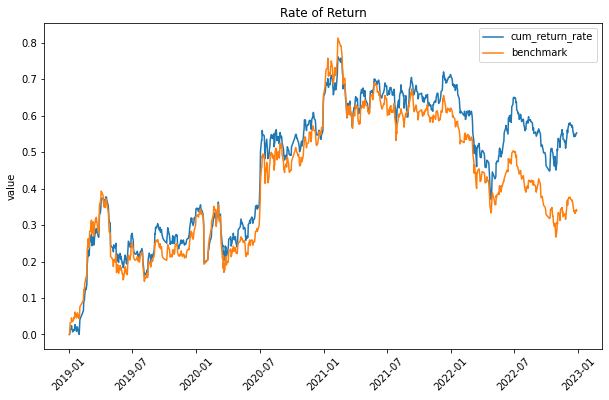

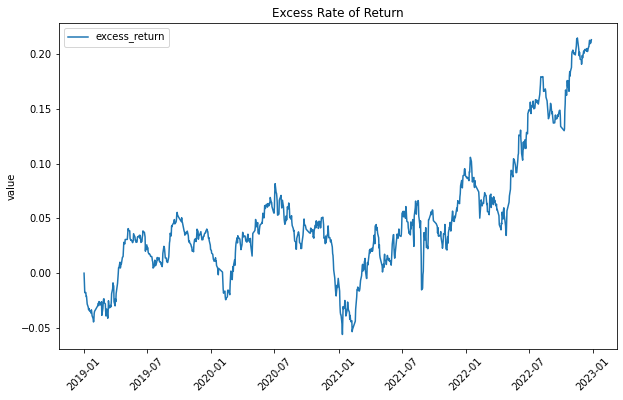

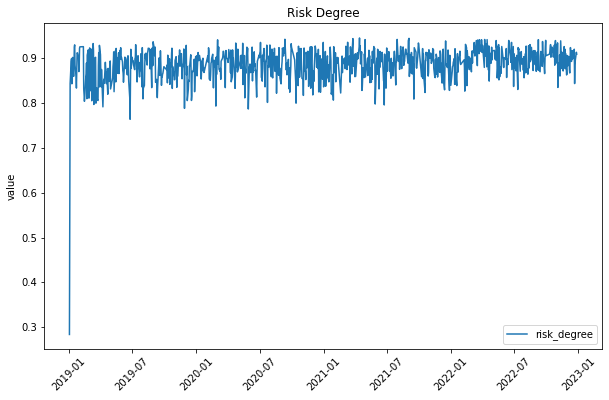

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节